This notebook contains the code for computing the climatology of a given period, and the residual obtained by subtracting such climatology from data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd
import gdown

In [2]:
!gdown '1o0xA60xYw0BLSlBnHqPBPsugZcmJ2hqI' #l3s from Copernico
!gdown '1CckeQ7Nre4UpITPgWYXI-HF_Le8MtFMh' #date and time
!gdown '15qwLkJA8CpseRcMgFmms4JM5Wz13AXN3' #italy mask

Downloading...
From (original): https://drive.google.com/uc?id=1o0xA60xYw0BLSlBnHqPBPsugZcmJ2hqI
From (redirected): https://drive.google.com/uc?id=1o0xA60xYw0BLSlBnHqPBPsugZcmJ2hqI&confirm=t&uuid=2f48223f-6a30-47ae-9bca-044cc2e80ee8
To: /content/sst_l3s.npy
100% 4.12G/4.12G [01:10<00:00, 58.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CckeQ7Nre4UpITPgWYXI-HF_Le8MtFMh
To: /content/time_l3s.npy
100% 62.9k/62.9k [00:00<00:00, 77.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=15qwLkJA8CpseRcMgFmms4JM5Wz13AXN3
To: /content/italy_mask.npy
100% 65.7k/65.7k [00:00<00:00, 87.8MB/s]


In [3]:
date_n = np.load('/content/time_l3s.npy')
abs_dataset_n = np.load('/content/sst_l3s.npy')
print(abs_dataset_n.shape)

(7851, 256, 256)


In [4]:
land_sea_mask = np.load('/content/italy_mask.npy').astype(int)

Let us inspect a few data

In [5]:
# Convert the date arrays to pandas DatetimeIndex with datetime format, then get the day of the year for each date
#date_series_n = pd.to_datetime(date_n, unit='D', origin=pd.Timestamp('1970-01-01')) #for modis
date_series_n = pd.to_datetime(date_n, unit='D', origin=pd.Timestamp('1981-01-01'))  #for l3s
day_of_year_n = date_series_n.dayofyear

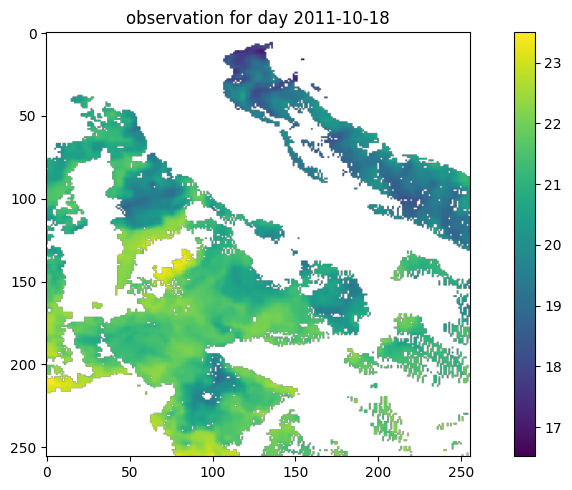

In [9]:
i = np.random.randint(0, abs_dataset_n.shape[0])
fig = plt.figure(figsize=(9, 5))

plt.title(f"observation for day {date_series_n[i].date()}")
im2 = plt.imshow(abs_dataset_n[i])
cb = fig.colorbar(im2, orientation='vertical', shrink=1)
plt.tight_layout()

plt.show()

He we define a couple of functions to perfom Gaussian Blur in presence of NaNs.

In [10]:
def nan_blur(a,sigma=(1,1,1)):
    truncate=3.0               # truncate filter at this many sigmas

    b=np.where(np.isnan(a),0,a)
    bb=ndimage.gaussian_filter(b,sigma=sigma,truncate=truncate)

    w=np.where(np.isnan(a),0.,1.)
    ww=ndimage.gaussian_filter(w,sigma=sigma,truncate=truncate)
    ww=np.where(ww==0,np.nan,ww)
    res=bb/ww
    return(res)

def blur_no_land(a,sigma=(1,1,1)):
    a = nan_blur(a,sigma=sigma)
    d = a.shape[0]
    land_sea_mask_d = np.tile(land_sea_mask,(d,1,1))
    a = np.where(land_sea_mask_d,a,np.nan)
    return(a)


# Climatology

We start with performing a slight spatial blur

In [11]:
abs_dataset_n = blur_no_land(abs_dataset_n,sigma=(0,2,2)) #only spatial

In [12]:
climatology = np.empty((366, 256, 256))

In [13]:
# For each day of the year, calculate the average temperature
for day in range(0, 366):
    # Get the indices of the dates that match the current day of the year for day and night
    #indices_d = np.where(day_of_year_d == day+1)    # Add 1 to day because day_of_year starts from 1
    indices_n = np.where(day_of_year_n == day+1)

    # Calculate the average temperature for the current day of the year for day and night, ignoring absent days
    #mean_temp_d = np.nanmean(abs_dataset_d[indices_d], axis=0) if indices_d[0].size > 0 else np.nan
    mean_temp_n = np.nanmean(abs_dataset_n[indices_n], axis=0) if indices_n[0].size > 0 else np.nan

    # Assign the mean temperatures to the baseline arrays
    climatology[day] = mean_temp_n

print(f"min_base={np.nanmin(climatology)},max_base={np.nanmax(climatology)}")

remaining_nans = np.sum(np.isnan(climatology)-(1-land_sea_mask))
print(f"still remaining {remaining_nans} nans")

<ipython-input-13-194780cbe090>:9: RuntimeWarning: Mean of empty slice
  mean_temp_n = np.nanmean(abs_dataset_n[indices_n], axis=0) if indices_n[0].size > 0 else np.nan


min_base=6.346343805012379,max_base=28.102564493085975
still remaining 0 nans


We perform a smoothing pass. This typically remove any trailing NaN, if any.

In [14]:
climatology = blur_no_land(climatology,sigma=(3,3,3))

remaining_nans = np.sum(np.isnan(climatology)-(1-land_sea_mask))
print(f"still remaining {remaining_nans} nans")

still remaining 0 nans


Let us visualize a few examples

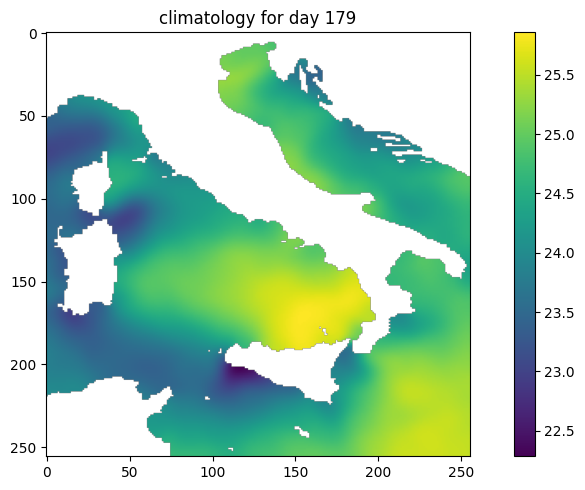

In [17]:
i = np.random.randint(0, climatology.shape[0])
fig = plt.figure(figsize=(9, 5))

plt.title(f"climatology for day {i}")
im2 = plt.imshow(climatology[i])
cb = fig.colorbar(im2, orientation='vertical', shrink=1)
plt.tight_layout()

plt.show()

Let's check the mean temperature over the year

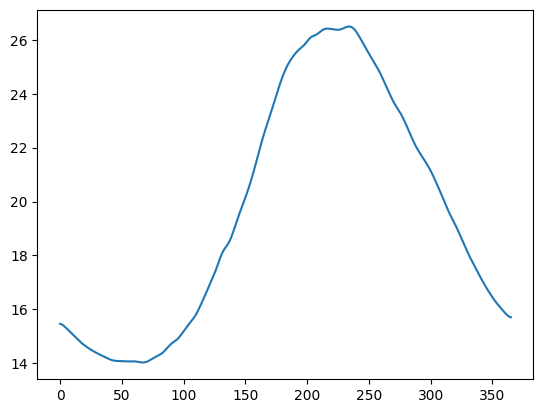

In [18]:
daily_temp_l3s = np.nanmean(climatology, axis=(1,2))
plt.plot(daily_temp_l3s)
plt.show()

In [19]:
np.save('climatology.npy',climatology)

# Residual
We can now compute the residual w.r.t. the climatology


In [20]:
residual_n = np.load('/content/sst_l3s.npy') #we reload sst since it was blurred

for i in range(residual_n.shape[0]):
    residual_n[i]= residual_n[i]-climatology[day_of_year_n[i]-1]

if True:
    np.save("l3s_residual_n.npy",residual_n)
    print("residual saved")

residual saved


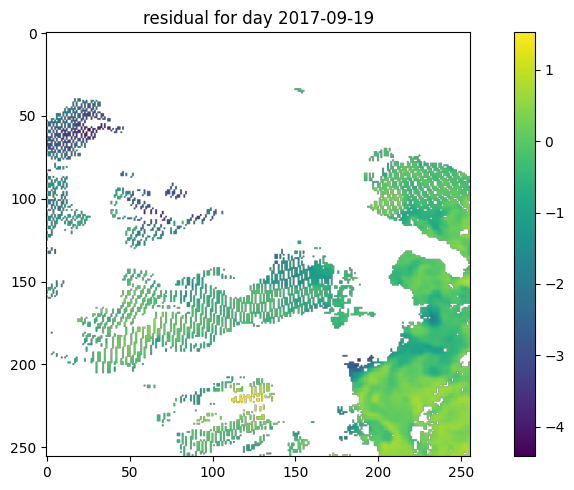

In [34]:
i = np.random.randint(0, residual_n.shape[0])
fig = plt.figure(figsize=(9, 5))

plt.title(f"residual for day {date_series_n[i].date()}")
im = plt.imshow(residual_n[i])
cb = fig.colorbar(im, orientation='vertical', shrink=1)
plt.tight_layout()

plt.show()